#  Hierarchical matrix scaling
### Exploring the computational scaling of hierarchical matrices for a simple geometry (straight crack in 2D)
[level- beginner]

Plane Elasticity problem 


In this notebook, we focus on the elasto-static problem of a straight fracture in an infinite isotropic medium under uniform remote tension (the Griffith crack), and explore the performance of the hierarchical matrix compression. 


We first import the Bigwham python interface, as well as a different libraries.

In [11]:
# imports etc.
import sys
import os
import numpy as np
# for plotting
import matplotlib.pyplot as plt

from bigwham4py import BEMatrix

### Discretization & hierarchical matrix creation
In this tutorial, we want to explore the computational performance of the hierarchical matrix algorithm for a simple geometry - a straigth crack in 2D. We will use piece-wise constant displacement discontinuity element for discretization. s

We write a small function to discretize a uniform mesh, and construct the corresponding hierarchical matrix for the hyper-singular 2D plane-strain elastic kernel (traction BIE).


In [12]:
import time

def create_h_mat_2DS0(nelts=20,eta=1,max_leaf_size=64,eps_aca=1.e-4,n_openMP_threads=16):

    a=1 # we fix the crack  to be in -1,1
    coor1D = np.linspace(-a, a, nelts + 1)  # the list of x coordinates of the element vertex
    coor = np.transpose(np.array([coor1D, coor1D * 0.0])) # the y coordinates is all zero.
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_) # the connectivity of the mesh is very simple 
    G = 1.0                # shear modulus in [Pa]
    nu = 0.1              # Poisson's ratio [-]
    E = (2 * G) * (1 + nu) # Young's modulus [Pa]
    elas_prop = np.array([E, nu]) # an array for the BigWham interface
    kernel_elt = "2DS0-H"  # 2D elastic P0 element (piece-wise constant displacement discontinuity for fracture)
    zt = time.process_time()
    h = BEMatrix(kernel_elt, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    mat_construct_time = (time.process_time() - zt)
    return h,mat_construct_time

Let's also write a function to time the computational cost of a matrix-vector dot product by the h-mat. (here results will depend on the hardware - and the number of active Threads). The number of active threads for a hmat object can be obtained via "h.get_omp_threads()"

In [13]:
import time
def time_dot_product(h):
    tinf = np.ones(h.shape[0])
# Testing matvec operation
    zt = time.time()
    for i in range(10):
        h @ tinf
    elapsed = (time.time() - zt) / 10
    return elapsed


Let's now time the mat-vect product while increasing the number of elements up to 200000. Caution, the following cells will take time (about 52 seconds on my 8 cores laptop).

In [14]:
list_of_nelts = np.array([20,50,200,500,2000,5000,20000,50000,200000]) # 
hmat_construct_time = list_of_nelts*0.
matvect_time = list_of_nelts*0.
h_compression = list_of_nelts*0.
i=0
for i in range(list_of_nelts.size):
    h,elasp = create_h_mat_2DS0(list_of_nelts[i],eta=3,max_leaf_size=64,eps_aca=1.e-4)
    matvect_time[i]= time_dot_product(h) 
    h_compression[i]=h.getCompression()
    hmat_construct_time[i]=elasp


NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.001008
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.001024
BigWham constructed Hmat of size (20 x 2) X (20 x 2)
--------------------
NUM OF AVAILAB

We can first visualize the cost of the hierarchical matrix creation, and its scaling. It scales as $\mathcal{O}(n \log n)$, where $n$ is the total number of unknowns ( here equal to 2*number of elts). An usual construction of the fully-populated matrix would yield a computation cost of  $\mathcal{O}(n^2)$ in comparison.

Text(0.5, 1.0, 'Hierarchical matrix construction scaling ')

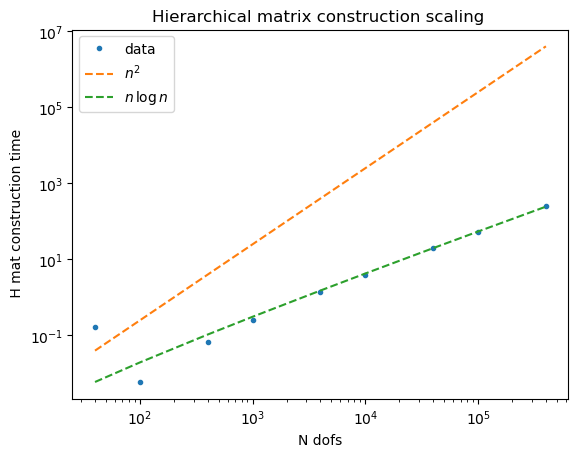

In [5]:
plt.plot(2*list_of_nelts,hmat_construct_time,'.')
plt.plot(2*list_of_nelts,1e-4*list_of_nelts*list_of_nelts,'--')
plt.plot(2*list_of_nelts,1e-4*list_of_nelts*np.log(list_of_nelts),'--')

plt.xlabel('N dofs')
plt.ylabel(' H mat construction time')
plt.yscale("log")
plt.xscale("log")
plt.legend(['data','$n^2$', '$n\, \log n$'])
plt.title('Hierarchical matrix construction scaling ')

Text(0.5, 1.0, 'H-Matrix-vector product scaling ')

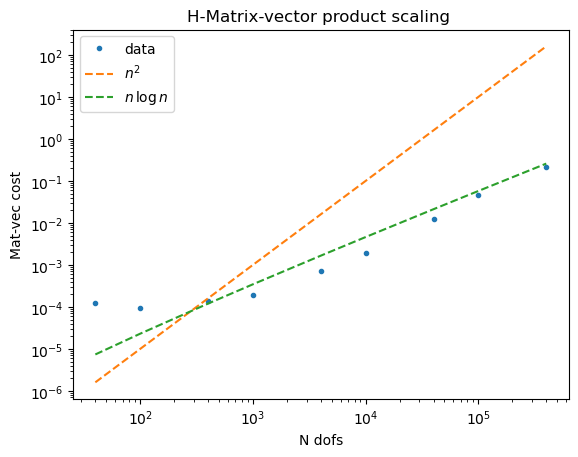

In [6]:
plt.plot(2*list_of_nelts,matvect_time,'.')
plt.plot(2*list_of_nelts,1e-9*4*list_of_nelts*list_of_nelts,'--')
plt.plot(2*list_of_nelts,1e-7*list_of_nelts*np.log(2*list_of_nelts),'--')

plt.xlabel('N dofs')
plt.ylabel('Mat-vec cost')
plt.yscale("log")
plt.xscale("log")
plt.legend(['data','$n^2$', '$n\, \log n$'])
plt.title('H-Matrix-vector product scaling ')


Text(0.5, 1.0, 'H-matrix compression scaling ')

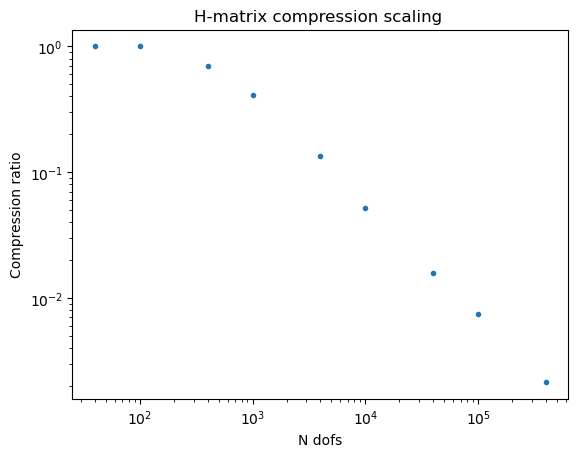

In [7]:
plt.plot(2*list_of_nelts,h_compression,'.') 
plt.xlabel('N dofs')
plt.ylabel('Compression ratio')
plt.yscale("log")
plt.xscale("log")
plt.title('H-matrix compression scaling ')
